In [4]:
#!conda install seaborn -q -y
#!conda install pandas -q -y
import seaborn as sns
import pandas
sns.__version__, pandas.__version__


('0.7.1', '0.18.1')

In [5]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
#plt.style.use('ggplot')

'%.4f'

In [8]:
np.random.seed(1234)
#!conda install pymc -q -y
import pymc
import scipy.stats as stats

## Estimating parameters of the 1DHL flash method response

### One Dimensional Model with heat losses
Analytical formula for temperature response at the rear face of the sample ($x=L$, $t>0$) is
$$ T(t, a, B_1, B_2) = \sum_{i=0}^\infty \frac{ 2\gamma_i^2(\gamma_i^2+B_2^2)\big(\cos{\gamma_i}+\frac{B_1}{\gamma_i}\sin{\gamma_i}\big)}{(\gamma_i^2+B_1^2)(\gamma_i^2+B_2^2)+(B_1+B_2)(\gamma_i^2+B_1B_2)}\exp{\big[-\gamma_i^2\frac{at}{L^2}\big]}, $$
where $\gamma_i$, $i=1,2,3,\dots$, are positive roots of 
$$ (\gamma^2-B_1B_2)\sin{\gamma} - (B_1+B_2)\cos{\gamma}=0.$$

$B_1$ and $B_2$ are Biot numbers for the front and rear side of the sample, resp. 

In [9]:
def flash1DHL( a, b, c, t,): # One dimensional model with heat losses
    
    # calculate eigenvalues - root of the transcendental functions
    gamas = mroots(funA, b, 0.0001, 200)
    
    Bi1=b
    Bi2=b

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)  
    
    return c*suma

In [5]:
# observed data
n = 15 # number of experimental points
a = 0.5 # diffusivity
c = 2 # tmax
Bio=0.1
b = Bio # Biot number
sigma = 0.03
x = np.linspace(0.01, 2.5, n)

y_obs = flash1DHL(a, b, c, x) + np.random.normal(0, sigma, n)
data = pd.DataFrame(np.array([x, y_obs]).T, columns=['x', 'y'])

NameError: name 'mroots' is not defined

In [13]:
data.plot(x='x', y='y', kind='scatter', s=50);

NameError: name 'data' is not defined

In [11]:
# define priors
a = pymc.Normal('alpha', mu=0.45, tau=1.0/10**2)
b = pymc.Normal('biot', mu=0.09, tau=1.0/10**2)
c = pymc.Normal('tmax', mu=1.99, tau=1.0/10**2)
tau = pymc.Gamma("tau", alpha=0.01, beta=0.01)


# define likelihood
@pymc.deterministic
def mu( a=a, b=b, c=c, x=x): # One dimensional model with heat losses
    
    # calculate eigenvalues - root of the transcendental functions
    gamas = mroots(funA, b, 0.001, 200)
    
    Bi1 = b
    Bi2 = b

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*x/L**2)  
    
    return c*suma

y = pymc.Normal('y', mu=mu, tau=tau, value=y_obs, observed=True)

# inference
m = pymc.Model([a, b, c, tau, x, y])
mc = pymc.MCMC(m)
mc.sample(iter=1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 480.5 sec

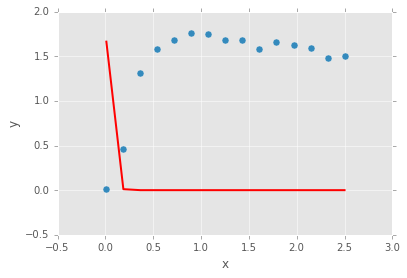

In [12]:
abar = a.stats()['mean']
bbar = b.stats()['mean']
cbar = c.stats()['mean']
data.plot(x='x', y='y', kind='scatter', s=50);
xp = np.array(x)  #[x.min(), x.max()])
#plt.plot(xp, flash1DHL(a.trace(), b.trace(),c.trace(), xp[:, None]), c='red', alpha=0.01)
plt.plot(xp, flash1DHL(abar,bbar, cbar,xp), linewidth=2, c='red');

Plotting tau
Plotting alpha
Plotting tmax
Plotting biot


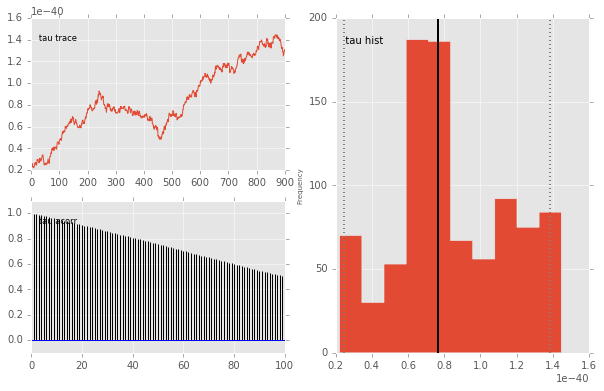

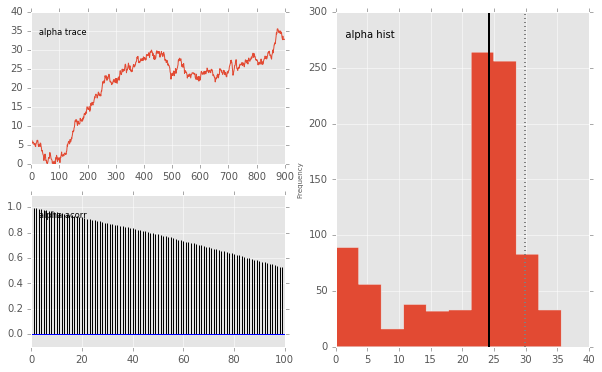

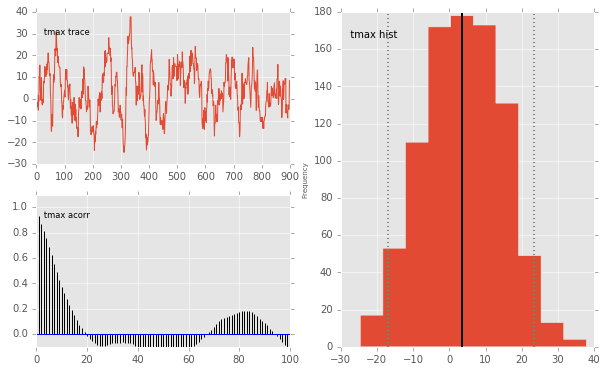

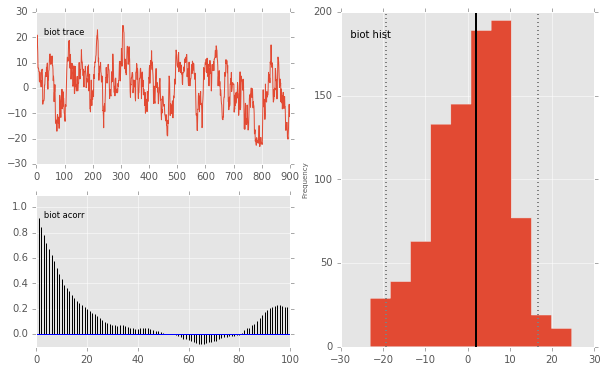

In [13]:
pymc.Matplot.plot(mc, )

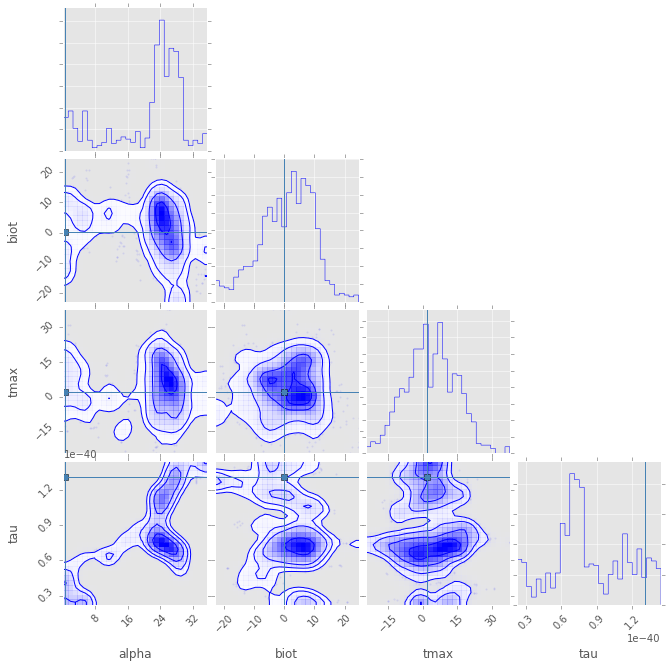

In [14]:

import numpy as np
samples = np.array([a.trace(),b.trace(), c.trace(), tau.trace()]).T
# pip install corner or pip install triangle_plot
import corner
figure = corner.corner(samples, color="b", bins=30, filled= True, smooth=(1.5),fill_contours=False,
                       labels=['alpha','biot', 'tmax', 'tau'], 
                truths=[0.5, 0.1,2.0, tau])

In [15]:
abar = a.stats()['mean']
bbar = b.stats()['mean']
cbar = c.stats()['mean']
abar, bbar, cbar

(20.9342, 0.7985, 3.6216)